https://tutorials.pytorch.kr/beginner/transformer_tutorial.html

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('./mount')

Mounted at ./mount


## Modules

In [ ]:
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torch.utils.data import Dataset

## Model

In [ ]:
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, max_smiles_length, additional_features_count, dropout, use_mask=False).to(DEVICE)

In [ ]:
model.forward_before_fc(X).shape

torch.Size([100, 18, 40])

In [ ]:
model.forward_before_fc_nomask(X).shape

torch.Size([100, 18, 40])

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, d_model, nhead, d_hid,
                 nlayers, max_smiles_length, additional_features_count, dropout = 0.5, use_mask=True):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, max_smiles_length, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.use_mask = use_mask
        self.gelu = nn.GELU()
        self.fc1 = nn.Linear(d_model, 1)  # MLM or HLM 값 하나를 예측
        self.fc2 = nn.Linear(max_smiles_length+additional_features_count, 128)  # middle layer
        self.fc3 = nn.Linear(128, 64)  # middle layer
        self.fc4 = nn.Linear(64, 1)

        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.init_weights()

    def get_mask(self, src):
        mask = src == 0
        return mask.transpose(0, 1).to(DEVICE)

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc3.bias.data.zero_()
        self.fc3.weight.data.uniform_(-initrange, initrange)
        self.fc4.bias.data.zero_()
        self.fc4.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_numeric) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        mask = self.get_mask(src)
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if self.use_mask:
            output = self.transformer_encoder(src, src_key_padding_mask=mask)
        else:
            output = self.transformer_encoder(src)
        output = self.fc1(output)
        output = output.transpose(0, 2)[0]  # [0]: (1, 18, 100) -> (18, 100)
        output = torch.cat([output, src_numeric.transpose(0, 1)], axis=1)
        # output = self.gelu(self.bn2(self.fc2(output)))
        # output = self.gelu(self.bn3(self.fc3(output)))
        output = self.gelu(self.fc2(output))
        output = self.gelu(self.fc3(output))
        output = self.fc4(output)
        return output

    def forward_embed(self, src):
        src = self.encoder(src) * math.sqrt(self.d_model)
        return src

    def forward_before_fc(self, src):
        mask = self.get_mask(src)
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=mask)
        return output

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Data

In [ ]:
from collections import Counter
import numpy as np
from tqdm import tqdm

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
class Tokenizer:
    def __init__(self, smiles_list):
        """
        Args:
            smiles_list (list): DataFrame의 SMILES Columns
        """
        self.smiles_list = smiles_list
        self.get_token_map()

    def get_token_map(self):
        token_count = []
        for smiles in self.smiles_list:
            smiles_sep = list(smiles)  # 'CCO' --> ['C', 'C', 'O']
            token_count.extend(smiles_sep)
        token_count = Counter(token_count)
        self.token_map = {}
        self.token_map['<pad>'] = 0
        for idx, k in enumerate(token_count, start=1):
            self.token_map[k] = idx
        self.unk = idx + 1  # unknown idx

    def tokenize(self, smiles):
        """
        Args:
            smiles (list): ex) ['C', 'C', 'O', '1', '<pad>', '<pad>' ,...]
        """
        tokenized_list = []
        for s in smiles:
            token_idx = self.token_map.get(s, self.unk)  # map에 없는 값일 경우 self.unk(=33) 할당
            tokenized_list.append(token_idx)
        return tokenized_list

    def token_count(self):
        return self.unk + 1  # 0부터 시작

In [ ]:
train_data.X.shape

torch.Size([100, 2998])

In [ ]:
torch.tensor(df_train_numeric, dtype=torch.float64).transpose(0, 1)

torch.Size([7, 2998])

In [ ]:
class SmilesDataset(Dataset):
    def __init__(self, df, df_numeric, target_column, tokenizer, max_smiles_length, batch_size):
        """
        Args:
            df_numeric (np.array): 데이터에서 추가로 사용할 설명변수
        """
        self.df = df
        self.tokenizer = tokenizer
        self.max_smiles_length = max_smiles_length
        self.batch_size = batch_size
        self.smiles_to_tokens(df['SMILES'].tolist())
        # torch.int16이 아닌 long(=int64)을 쓰는 이유는 embedding에서 long밖에 받지 못하기 때문
        self.X = torch.tensor(self.X, dtype=torch.long).transpose(0, 1)  # max_smiles_length by 데이터 개수. train data의 경우 100 x 3498
        self.X_numeric = torch.tensor(df_numeric, dtype=torch.float32).transpose(0, 1)
        self.y = df[target_column].tolist()
        self.y = torch.tensor(self.y, dtype=torch.float32).unsqueeze(1)  # train data의 경우 3498 x 1

    def smiles_to_tokens(self, smiles_list):
        """
        Args:
            smiles_list (list): DataFrame의 SMILES Columns
        Returns:
            token_data (list-2d): (data 개수) by (max_smiles_length)
        """
        self.X = []
        for smiles in smiles_list:
            smiles_padded = list(smiles[:self.max_smiles_length])
            padding_count = self.max_smiles_length - len(smiles_padded)  # <pad> 개수
            padding_list = ['<pad>'] * padding_count  # if padding_count == 0, then padding_list = []
            smiles_padded.extend(padding_list)
            tokens = self.tokenizer.tokenize(smiles_padded)  # 길이가 100인 list. ex) [1, 2, 0, ...., 33]
            self.X.append(tokens)

    def __getitem__(self, i):
        idx = i*self.batch_size
        X = self.X[:, idx:idx+self.batch_size]
        X_numeric = self.X_numeric[:, idx:idx+self.batch_size]
        y = self.y[idx:idx+self.batch_size]
        return X.to(DEVICE), X_numeric.to(DEVICE), y.to(DEVICE)

    def __len__(self):
        return len(self.df) // self.batch_size

In [ ]:
cd /content/mount/MyDrive/study/transformer

/content/mount/MyDrive/study/transformer


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train = pd.read_csv('data/train.csv')

In [ ]:
tokenizer.tokenize(['C', '(', '%', '<pad>']) # '%'는 없는 토큰이므로 33을 할당

[1, 5, 33, 0]

<Axes: ylabel='Frequency'>

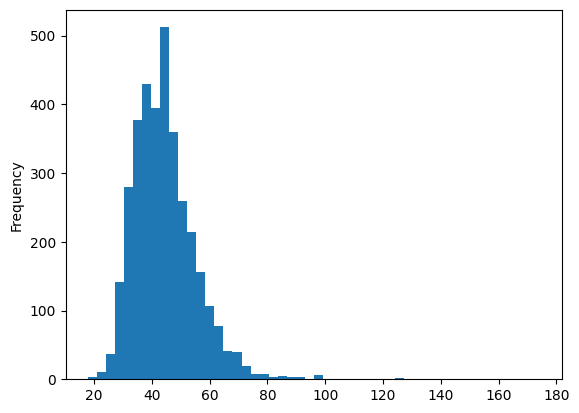

In [ ]:
train['SMILES'].str.len().plot(kind='hist', bins=50)

In [ ]:
train['AlogP'] = train['AlogP'].fillna(0)

In [ ]:
df_train, df_val = train[:3000], train[3000:]

In [ ]:
smiles_unique_count = train.groupby('SMILES').size()

In [ ]:
smiles_test = smiles_unique_count[smiles_unique_count == 1].sample(500, random_state=42).index

In [ ]:
df_train, df_val = train[~train['SMILES'].isin(smiles_test)], train[train['SMILES'].isin(smiles_test)]

#### scaling

In [ ]:
scale_columns = ['AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea']

In [ ]:
scaler = StandardScaler()
df_train_numeric = scaler.fit_transform(df_train[scale_columns])
df_val_numeric = scaler.transform(df_val[scale_columns])

In [ ]:
print(df_train_numeric.shape, df_val_numeric.shape)

(2998, 7) (500, 7)


In [ ]:
# max_smiles_length = train['SMILES'].str.len().max()  # 174
max_smiles_length = 100

In [ ]:
tokenizer = Tokenizer(df_train['SMILES'].tolist())

In [ ]:
batch_size = 20
target_column = 'HLM'
train_data = SmilesDataset(df_train, df_train_numeric, target_column, tokenizer, max_smiles_length, 20)

val_data = SmilesDataset(df_val, df_val_numeric, target_column, tokenizer, max_smiles_length, 20)

## Train

https://aladdinpersson.medium.com/how-to-get-a-progress-bar-in-pytorch-72bdbf19b35c

In [ ]:
# v11: 1060, 30
ntokens = tokenizer.token_count() # Token size
emsize = 40 # 임베딩 차원  # 어차피 단어한개라서 임베딩사이즈를 키움안되는구나
d_hid = 100 # ``nn.TransformerEncoder`` 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # ``nn.TransformerEncoder`` 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # ``nn.MultiheadAttention`` 의 헤드 개수
additional_features_count = df_train_numeric.shape[1]  # 7
dropout = 0.1 # 드랍아웃(dropout) 확률

In [ ]:
# v11:
ntokens = tokenizer.token_count() # Token size
emsize = 10 # 임베딩 차원  # 어차피 단어한개라서 임베딩사이즈를 키움안되는구나
d_hid = 50 # ``nn.TransformerEncoder`` 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # ``nn.TransformerEncoder`` 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # ``nn.MultiheadAttention`` 의 헤드 개수
additional_features_count = df_train_numeric.shape[1]  # 7
dropout = 0.1 # 드랍아웃(dropout) 확률

In [ ]:
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, max_smiles_length, additional_features_count, dropout, use_mask=False).to(DEVICE)

In [ ]:
mse_loss = nn.MSELoss()
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
NUM_EPOCHS = 30

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    loss_log = []
    loop = tqdm(range(len(train_data) + 1))
    for i in loop:
        X, X_numeric, y = train_data[i][0], train_data[i][1], train_data[i][2]
        if X.shape[-1] == 0:  # train data size % batch size == 0일때, 마지막 iter의 X는 길이가 0이 됨.
            continue
        output = model(X, X_numeric)
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=np.mean(loss_log))
    # Validate
    _loss_log = []
    _loss_log_target = []  # mse
    model.eval()
    for j in range(len(val_data)+1):
        _X, _X_numeric, _y = val_data[j][0], val_data[j][1], val_data[j][2]
        if _X.shape[-1] == 0:  # train data size % batch size == 0일때, 마지막 iter의 X는 길이가 0이 됨.
            continue
        with torch.no_grad():
            _output = model(_X, _X_numeric)
        _loss = criterion(_output, _y)
        _loss_mse = mse_loss(_output, _y)
        _loss_log.append(_loss.item())
        _loss_log_target.append(_loss_mse.item())
    print('val loss:', np.mean(_loss_log_target), np.mean(_loss_log))

Epoch [1/30]: 100%|██████████| 150/150 [00:01<00:00, 82.38it/s, loss=4.03e+3]


val loss: 3680.50345703125 3680.50345703125


Epoch [2/30]: 100%|██████████| 150/150 [00:01<00:00, 81.42it/s, loss=2.58e+3]


val loss: 1436.90115234375 1436.90115234375


Epoch [3/30]: 100%|██████████| 150/150 [00:01<00:00, 77.27it/s, loss=1.29e+3]


val loss: 1270.5697021484375 1270.5697021484375


Epoch [4/30]: 100%|██████████| 150/150 [00:02<00:00, 68.86it/s, loss=1.25e+3]


val loss: 1242.2838793945311 1242.2838793945311


Epoch [5/30]: 100%|██████████| 150/150 [00:02<00:00, 68.79it/s, loss=1.22e+3]


val loss: 1208.0026123046875 1208.0026123046875


Epoch [6/30]: 100%|██████████| 150/150 [00:01<00:00, 83.79it/s, loss=1.19e+3]


val loss: 1174.6584252929688 1174.6584252929688


Epoch [7/30]: 100%|██████████| 150/150 [00:01<00:00, 82.03it/s, loss=1.17e+3]


val loss: 1147.0414135742187 1147.0414135742187


Epoch [8/30]: 100%|██████████| 150/150 [00:01<00:00, 80.05it/s, loss=1.15e+3]


val loss: 1125.6057006835938 1125.6057006835938


Epoch [9/30]: 100%|██████████| 150/150 [00:01<00:00, 80.22it/s, loss=1.13e+3]


val loss: 1109.8106982421875 1109.8106982421875


Epoch [10/30]: 100%|██████████| 150/150 [00:01<00:00, 79.33it/s, loss=1.12e+3]


val loss: 1098.64296875 1098.64296875


Epoch [11/30]: 100%|██████████| 150/150 [00:02<00:00, 73.32it/s, loss=1.12e+3]


val loss: 1090.9344470214844 1090.9344470214844


Epoch [12/30]: 100%|██████████| 150/150 [00:02<00:00, 65.71it/s, loss=1.11e+3]


val loss: 1085.6352905273438 1085.6352905273438


Epoch [13/30]: 100%|██████████| 150/150 [00:01<00:00, 81.32it/s, loss=1.11e+3]


val loss: 1081.9796826171876 1081.9796826171876


Epoch [14/30]: 100%|██████████| 150/150 [00:01<00:00, 81.37it/s, loss=1.11e+3]


val loss: 1079.3917602539063 1079.3917602539063


Epoch [15/30]: 100%|██████████| 150/150 [00:01<00:00, 81.17it/s, loss=1.11e+3]


val loss: 1077.5341455078126 1077.5341455078126


Epoch [16/30]: 100%|██████████| 150/150 [00:01<00:00, 81.22it/s, loss=1.1e+3]


val loss: 1076.1595385742187 1076.1595385742187


Epoch [17/30]: 100%|██████████| 150/150 [00:01<00:00, 80.89it/s, loss=1.1e+3]


val loss: 1075.0885021972656 1075.0885021972656


Epoch [18/30]: 100%|██████████| 150/150 [00:02<00:00, 71.93it/s, loss=1.1e+3]


val loss: 1074.2483410644531 1074.2483410644531


Epoch [19/30]: 100%|██████████| 150/150 [00:02<00:00, 66.67it/s, loss=1.1e+3]


val loss: 1073.5342248535155 1073.5342248535155


Epoch [20/30]: 100%|██████████| 150/150 [00:02<00:00, 71.12it/s, loss=1.1e+3]


val loss: 1072.9341442871093 1072.9341442871093


Epoch [21/30]: 100%|██████████| 150/150 [00:01<00:00, 78.14it/s, loss=1.1e+3]


val loss: 1072.424736328125 1072.424736328125


Epoch [22/30]: 100%|██████████| 150/150 [00:01<00:00, 79.34it/s, loss=1.1e+3]


val loss: 1071.9551525878906 1071.9551525878906


Epoch [23/30]: 100%|██████████| 150/150 [00:01<00:00, 78.38it/s, loss=1.1e+3]


val loss: 1071.52484375 1071.52484375


Epoch [24/30]: 100%|██████████| 150/150 [00:01<00:00, 77.01it/s, loss=1.1e+3]


val loss: 1071.1098693847657 1071.1098693847657


Epoch [25/30]: 100%|██████████| 150/150 [00:02<00:00, 71.32it/s, loss=1.1e+3]


val loss: 1070.733779296875 1070.733779296875


Epoch [26/30]: 100%|██████████| 150/150 [00:02<00:00, 67.30it/s, loss=1.1e+3]


val loss: 1070.3789990234375 1070.3789990234375


Epoch [27/30]: 100%|██████████| 150/150 [00:02<00:00, 70.79it/s, loss=1.1e+3]


val loss: 1070.0175048828125 1070.0175048828125


Epoch [28/30]: 100%|██████████| 150/150 [00:01<00:00, 80.59it/s, loss=1.1e+3]


val loss: 1069.6776440429687 1069.6776440429687


Epoch [29/30]: 100%|██████████| 150/150 [00:01<00:00, 77.87it/s, loss=1.1e+3]


val loss: 1069.3261462402343 1069.3261462402343


Epoch [30/30]: 100%|██████████| 150/150 [00:01<00:00, 79.83it/s, loss=1.1e+3]


val loss: 1068.9934680175782 1068.9934680175782


## Submit

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
test['MLM'] = 0
test['HLM'] = 0

In [ ]:
train['AlogP'] = train['AlogP'].fillna(train['AlogP'].mean())

In [ ]:
test['AlogP'] = test['AlogP'].fillna(train['AlogP'].mean())

In [ ]:
scaler = StandardScaler()
train_numeric = scaler.fit_transform(train[scale_columns])
test_numeric = scaler.transform(test[scale_columns])

In [ ]:
batch_size = 20
train_data_mlm = SmilesDataset(train, train_numeric, 'MLM', tokenizer, max_smiles_length, 20)
train_data_hlm = SmilesDataset(train, train_numeric, 'HLM', tokenizer, max_smiles_length, 20)

In [ ]:
test_data_mlm = SmilesDataset(test, test_numeric, 'MLM', tokenizer, max_smiles_length, 20)
test_data_hlm = SmilesDataset(test, test_numeric, 'HLM', tokenizer, max_smiles_length, 20)

In [ ]:
tokenizer = Tokenizer(train['SMILES'].tolist())

In [ ]:
ntokens = tokenizer.token_count() # Token size
emsize = 100 # 임베딩 차원
d_hid = 200 # ``nn.TransformerEncoder`` 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # ``nn.TransformerEncoder`` 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # ``nn.MultiheadAttention`` 의 헤드 개수
dropout = 0.1 # 드랍아웃(dropout) 확률

In [ ]:
# v11: 1060, 30
ntokens = tokenizer.token_count() # Token size
emsize = 40 # 임베딩 차원  # 어차피 단어한개라서 임베딩사이즈를 키움안되는구나
d_hid = 100 # ``nn.TransformerEncoder`` 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # ``nn.TransformerEncoder`` 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # ``nn.MultiheadAttention`` 의 헤드 개수
additional_features_count = df_train_numeric.shape[1]  # 7
dropout = 0.1 # 드랍아웃(dropout) 확률

In [ ]:
model_mlm = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, max_smiles_length, additional_features_count, dropout, use_mask=False).to(DEVICE)
model_hlm = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, max_smiles_length, additional_features_count, dropout, use_mask=False).to(DEVICE)

In [ ]:
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer_mlm = torch.optim.AdamW(model_mlm.parameters(), lr=1e-4)
optimizer_hlm = torch.optim.AdamW(model_hlm.parameters(), lr=1e-4)

In [ ]:
NUM_EPOCHS = 30

In [ ]:
best_loss = np.inf
for epoch in range(NUM_EPOCHS):
    model_mlm.train()
    loss_log = []
    loop = tqdm(range(len(train_data_mlm) + 1))
    for i in loop:
        X, X_numeric, y = train_data_mlm[i][0], train_data_mlm[i][1], train_data_mlm[i][2]
        if X.shape[-1] == 0:  # train data size % batch size == 0일때, 마지막 iter의 X는 길이가 0이 됨.
            continue
        output = model_mlm(X, X_numeric)
        loss = criterion(output, y)
        optimizer_mlm.zero_grad()
        loss.backward()
        optimizer_mlm.step()
        loss_log.append(loss.item())

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=np.mean(loss_log))
    if np.mean(loss_log) < best_loss:
        print('saved model')
        torch.save(model_mlm.state_dict(), 'checkpoint/model_mlm.pt')
        best_loss = np.mean(loss_log)

Epoch [0/30]: 100%|██████████| 175/175 [00:02<00:00, 67.14it/s, loss=2.21e+3]


saved model


Epoch [1/30]: 100%|██████████| 175/175 [00:02<00:00, 58.55it/s, loss=1.27e+3]


saved model


Epoch [2/30]: 100%|██████████| 175/175 [00:02<00:00, 64.86it/s, loss=1.25e+3]


saved model


Epoch [3/30]: 100%|██████████| 175/175 [00:02<00:00, 60.69it/s, loss=1.23e+3]


saved model


Epoch [4/30]: 100%|██████████| 175/175 [00:02<00:00, 66.94it/s, loss=1.21e+3]


saved model


Epoch [5/30]: 100%|██████████| 175/175 [00:02<00:00, 63.23it/s, loss=1.19e+3]


saved model


Epoch [6/30]: 100%|██████████| 175/175 [00:02<00:00, 80.76it/s, loss=1.17e+3]


saved model


Epoch [7/30]: 100%|██████████| 175/175 [00:02<00:00, 80.10it/s, loss=1.15e+3]


saved model


Epoch [8/30]: 100%|██████████| 175/175 [00:02<00:00, 78.96it/s, loss=1.13e+3]


saved model


Epoch [9/30]: 100%|██████████| 175/175 [00:03<00:00, 49.01it/s, loss=1.11e+3]


saved model


Epoch [10/30]: 100%|██████████| 175/175 [00:03<00:00, 51.21it/s, loss=1.1e+3]


saved model


Epoch [11/30]: 100%|██████████| 175/175 [00:02<00:00, 68.70it/s, loss=1.09e+3]


saved model


Epoch [12/30]: 100%|██████████| 175/175 [00:02<00:00, 76.40it/s, loss=1.09e+3]


saved model


Epoch [13/30]: 100%|██████████| 175/175 [00:02<00:00, 77.19it/s, loss=1.08e+3]


saved model


Epoch [14/30]: 100%|██████████| 175/175 [00:02<00:00, 79.52it/s, loss=1.08e+3]


saved model


Epoch [15/30]: 100%|██████████| 175/175 [00:02<00:00, 75.41it/s, loss=1.08e+3]


saved model


Epoch [16/30]: 100%|██████████| 175/175 [00:02<00:00, 66.08it/s, loss=1.07e+3]


saved model


Epoch [17/30]: 100%|██████████| 175/175 [00:02<00:00, 66.12it/s, loss=1.07e+3]


saved model


Epoch [18/30]: 100%|██████████| 175/175 [00:02<00:00, 76.79it/s, loss=1.07e+3]


saved model


Epoch [19/30]: 100%|██████████| 175/175 [00:02<00:00, 79.64it/s, loss=1.07e+3]


saved model


Epoch [20/30]: 100%|██████████| 175/175 [00:02<00:00, 78.71it/s, loss=1.06e+3]


saved model


Epoch [21/30]: 100%|██████████| 175/175 [00:02<00:00, 75.90it/s, loss=1.06e+3]


saved model


Epoch [22/30]: 100%|██████████| 175/175 [00:04<00:00, 43.62it/s, loss=1.05e+3]


saved model


Epoch [23/30]: 100%|██████████| 175/175 [00:02<00:00, 65.19it/s, loss=1.05e+3]


saved model


Epoch [24/30]: 100%|██████████| 175/175 [00:02<00:00, 76.30it/s, loss=1.05e+3]


saved model


Epoch [25/30]: 100%|██████████| 175/175 [00:02<00:00, 75.50it/s, loss=1.04e+3]


saved model


Epoch [26/30]: 100%|██████████| 175/175 [00:02<00:00, 76.78it/s, loss=1.04e+3]


saved model


Epoch [27/30]: 100%|██████████| 175/175 [00:02<00:00, 72.68it/s, loss=1.03e+3]


saved model


Epoch [28/30]: 100%|██████████| 175/175 [00:02<00:00, 67.53it/s, loss=1.03e+3]


saved model


Epoch [29/30]: 100%|██████████| 175/175 [00:02<00:00, 66.70it/s, loss=1.03e+3]


saved model


In [ ]:
best_loss = np.inf
for epoch in range(NUM_EPOCHS):
    model_hlm.train()
    loss_log = []
    loop = tqdm(range(len(train_data_hlm) + 1))
    for i in loop:
        X, X_numeric, y = train_data_hlm[i][0], train_data_hlm[i][1], train_data_hlm[i][2]
        if X.shape[-1] == 0:  # train data size % batch size == 0일때, 마지막 iter의 X는 길이가 0이 됨.
            continue
        output = model_hlm(X, X_numeric)
        loss = criterion(output, y)
        optimizer_hlm.zero_grad()
        loss.backward()
        optimizer_hlm.step()
        loss_log.append(loss.item())

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=np.mean(loss_log))
    if np.mean(loss_log) < best_loss:
        print('saved model')
        torch.save(model_hlm.state_dict(), 'checkpoint/model_hlm.pt')
        best_loss = np.mean(loss_log)

Epoch [0/30]: 100%|██████████| 175/175 [00:02<00:00, 80.64it/s, loss=3.23e+3]


saved model


Epoch [1/30]: 100%|██████████| 175/175 [00:02<00:00, 80.32it/s, loss=1.31e+3]


saved model


Epoch [2/30]: 100%|██████████| 175/175 [00:02<00:00, 80.45it/s, loss=1.27e+3]


saved model


Epoch [3/30]: 100%|██████████| 175/175 [00:02<00:00, 79.63it/s, loss=1.25e+3]


saved model


Epoch [4/30]: 100%|██████████| 175/175 [00:02<00:00, 72.54it/s, loss=1.23e+3]


saved model


Epoch [5/30]: 100%|██████████| 175/175 [00:02<00:00, 65.25it/s, loss=1.21e+3]


saved model


Epoch [6/30]: 100%|██████████| 175/175 [00:02<00:00, 70.73it/s, loss=1.18e+3]


saved model


Epoch [7/30]: 100%|██████████| 175/175 [00:02<00:00, 79.96it/s, loss=1.16e+3]


saved model


Epoch [8/30]: 100%|██████████| 175/175 [00:02<00:00, 80.48it/s, loss=1.15e+3]


saved model


Epoch [9/30]: 100%|██████████| 175/175 [00:02<00:00, 79.30it/s, loss=1.14e+3]


saved model


Epoch [10/30]: 100%|██████████| 175/175 [00:02<00:00, 77.27it/s, loss=1.13e+3]


saved model


Epoch [11/30]: 100%|██████████| 175/175 [00:02<00:00, 66.21it/s, loss=1.12e+3]


saved model


Epoch [12/30]: 100%|██████████| 175/175 [00:02<00:00, 68.54it/s, loss=1.11e+3]


saved model


Epoch [13/30]: 100%|██████████| 175/175 [00:02<00:00, 80.49it/s, loss=1.1e+3]


saved model


Epoch [14/30]: 100%|██████████| 175/175 [00:02<00:00, 78.71it/s, loss=1.1e+3]


saved model


Epoch [15/30]: 100%|██████████| 175/175 [00:02<00:00, 78.58it/s, loss=1.1e+3]


saved model


Epoch [16/30]: 100%|██████████| 175/175 [00:02<00:00, 78.32it/s, loss=1.09e+3]


saved model


Epoch [17/30]: 100%|██████████| 175/175 [00:02<00:00, 64.02it/s, loss=1.09e+3]


saved model


Epoch [18/30]: 100%|██████████| 175/175 [00:02<00:00, 64.28it/s, loss=1.09e+3]


saved model


Epoch [19/30]: 100%|██████████| 175/175 [00:02<00:00, 77.35it/s, loss=1.08e+3]


saved model


Epoch [21/30]: 100%|██████████| 175/175 [00:02<00:00, 78.60it/s, loss=1.08e+3]


saved model


Epoch [22/30]: 100%|██████████| 175/175 [00:02<00:00, 78.73it/s, loss=1.08e+3]


saved model


Epoch [23/30]: 100%|██████████| 175/175 [00:02<00:00, 67.11it/s, loss=1.08e+3]


saved model


Epoch [24/30]: 100%|██████████| 175/175 [00:02<00:00, 63.95it/s, loss=1.08e+3]


saved model


Epoch [25/30]: 100%|██████████| 175/175 [00:02<00:00, 77.70it/s, loss=1.07e+3]


saved model


Epoch [27/30]: 100%|██████████| 175/175 [00:02<00:00, 79.08it/s, loss=1.07e+3]


saved model


Epoch [28/30]: 100%|██████████| 175/175 [00:02<00:00, 78.76it/s, loss=1.07e+3]


saved model


Epoch [29/30]: 100%|██████████| 175/175 [00:02<00:00, 72.92it/s, loss=1.07e+3]


saved model


### make file

In [ ]:
model_mlm = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, max_smiles_length, additional_features_count, dropout, use_mask=False).to(DEVICE)
model_hlm = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, max_smiles_length, additional_features_count, dropout, use_mask=False).to(DEVICE)

In [ ]:
weights_mlm = torch.load('checkpoint/model_mlm.pt')
weights_hlm = torch.load('checkpoint/model_hlm.pt')
model_mlm.load_state_dict(weights_mlm)
model_hlm.load_state_dict(weights_hlm)

<All keys matched successfully>

In [ ]:
mlm_pred = []
hlm_pred = []

In [ ]:
model_mlm.eval()
for j in range(len(test_data_mlm)+1):
    _X, _X_numeric = test_data_mlm[j][0], test_data_mlm[j][1]
    with torch.no_grad():
        _output = model_mlm(_X, _X_numeric)
        _output = _output.squeeze().tolist()
        mlm_pred.extend(_output)

In [ ]:
model_hlm.eval()
for j in range(len(test_data_hlm)+1):
    _X, _X_numeric = test_data_mlm[j][0], test_data_mlm[j][1]
    with torch.no_grad():
        _output = model_hlm(_X, _X_numeric)
        _output = _output.squeeze().tolist()
        hlm_pred.extend(_output)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
submission['MLM'] = train['MLM'].mean()
submission['HLM'] = train['HLM'].mean()

In [ ]:
submission.to_csv('submission_v1.csv', index=False)

In [ ]:
submission['MLM'] = mlm_pred
submission['HLM'] = hlm_pred

In [ ]:
sum(train['HLM'] < 0)

0

In [ ]:
print(sum(submission['MLM'] < 0), sum(submission['HLM'] < 0))

3 0


In [ ]:
submission.loc[submission['HLM'] < 0, 'HLM'] = 0

In [ ]:
print(sum(submission['MLM'] < 0), sum(submission['HLM'] < 0))

3 0


In [ ]:
submission.to_csv('submission_v2.csv', index=False)

In [ ]:
ls

checkpoint/  seq_to_seq.ipynb  stock.ipynb        submission_v2.csv
data/        smiles.ipynb      submission_v1.csv  Untitled0.ipynb
